In [1]:
from tools.log_controller import LogController
from pathlib import Path

log_controller = LogController(config_path=Path('config', 'logging_config.json'))
log_controller.start()

 2025-09-20 10:19:54 - data_repository - INFO - Loaded: AAPL
 2025-09-20 10:19:54 - data_repository - INFO - Loaded: AMZN_enhanced
 2025-09-20 10:19:54 - data_repository - INFO - Loaded: IBM
 2025-09-20 10:19:54 - data_repository - INFO - Loaded: AMZN
 2025-09-20 10:19:54 - data_repository - INFO - Loaded periodic stock market data for: {'AAPL', 'AMZN_enhanced', 'AMZN', 'IBM'}


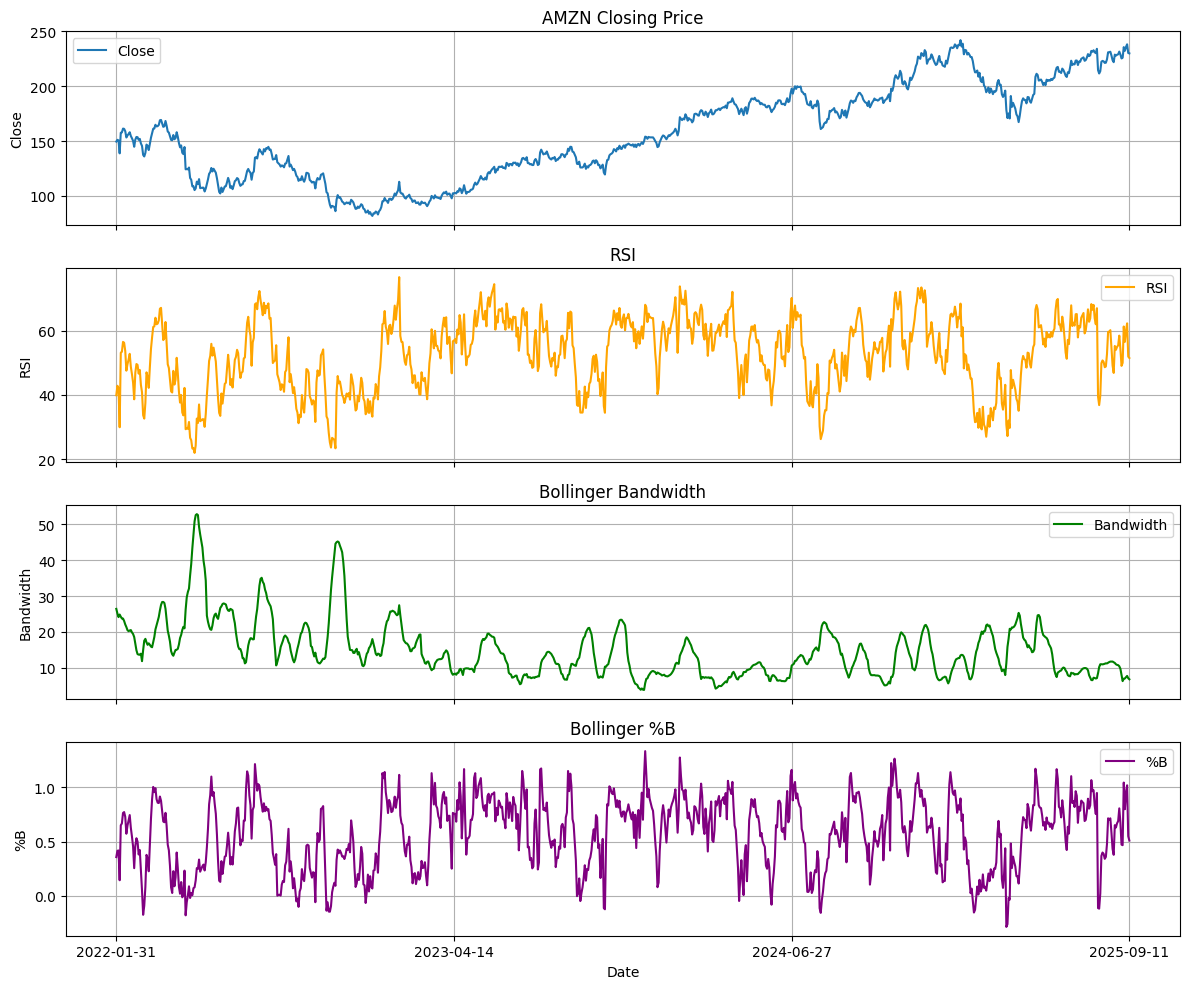

In [4]:
from core.data_repository import DataRepository
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

data_repository = DataRepository(repo_path=Path('repo'))
AMZN_periodic_data = data_repository.get_dataframes()['AMZN_enhanced']

fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
tick_positions = np.linspace(0, len(AMZN_periodic_data.index) - 1, 4, dtype=int)

# Plot Close
sns.lineplot(ax=axes[0], data=AMZN_periodic_data, x=AMZN_periodic_data.index, y='Close', label='Close')
axes[0].set_title('AMZN Closing Price')

# RSI
sns.lineplot(ax=axes[1], data=AMZN_periodic_data, x=AMZN_periodic_data.index, y='RSI', label='RSI', color='orange')
axes[1].set_title('RSI')

# Bandwidth
sns.lineplot(ax=axes[2], data=AMZN_periodic_data, x=AMZN_periodic_data.index, y='Bandwidth', label='Bandwidth', color='green')
axes[2].set_title('Bollinger Bandwidth')

# %B
sns.lineplot(ax=axes[3], data=AMZN_periodic_data, x=AMZN_periodic_data.index, y='%B', label='%B', color='purple')
axes[3].set_title('Bollinger %B')


for ax in axes:
    ax.set_xticks(AMZN_periodic_data.index[tick_positions])
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()
